In [1]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Synapses</h1>

We can describe the action of ligand gated ion channes in synapses through an explicitely time-dependend conductivity $g_{syn}(t)$ that will open whenever a presynaptic spike arrives. The current that passes through the synaptice channel is then given by $$I_{syn}(t) = g_{syn}(t)(u(t)-E_{syn})$$

Typically, a superposition of exponentials is used for $g_{syn}(t)$: $$g_{syn}(t) = \Sigma_f\overline{g}_{syn}e^{-\frac{t-t^{(f)}}{\tau}}\theta(t-t^{(f)})$$

In [52]:
# typical neuron parameters
u_rest = -65.       # resting potential [mV]
theta = -55.        # spike threshold [mV]
tau_m = 10.         # membrane time constant [ms]
Cm = 1.0            # Membrane capacitance per unit area (uF/cm^2)
g_L = 10.           # leak conductance [nS]
El = -65.           # Leak potential (mV)

gbar_syn = 40       # maximal synaptic conductance [pS]
ESyn_ex = 0.           # synaptic reversal potential [mV]
ESyn_in = -80.         # synaptic reversal potential [mV]

# Simulation parameters 
T = 40.  # Total duration of simulation [ms]
dt = .01   # Simulation time step [ms]

# Time vector
t = np.arange(0, T+dt, dt)

In [48]:
class Synapse():
    def __init__(self, u_rest, theta, tau_m, Cm, g_L, El, gbar_syn, tau_rise, tau_fast, tau_slow, a, Esyn):
        self.u_rest = u_rest
        self.theta = theta
        self.tau_m = tau_m
        self.Cm = Cm
        self.g_L = g_L
        self.EL = El
        self.gbar_syn = gbar_syn
        self.tau_rise = tau_rise
        self.tau_fast = tau_fast
        self.tau_slow = tau_slow
        self.a = a
        self.Esyn = Esyn

    # make it work as a function and return only one value
    def g_syn(self, ti, rec_spikes):
        g_syn = 0

        for spike in rec_spikes:
            if ti > spike:
                g_syn += self.gbar_syn * (1 - np.exp(-(ti - spike) / self.tau_rise)) * (self.a * np.exp(-(ti - spike) / self.tau_fast) + (1 - self.a) * np.exp(-(ti - spike) / self.tau_slow))
        
        return g_syn

    def Isyn(self, u, ti, rec_spikes):
        return self.g_syn(ti, rec_spikes) * (u - self.Esyn)

    def IL(self, u):
        return self.g_L * (u - self.EL)

    def u_dot(self, u, ti, rec_spikes):
            return (- self.Isyn(u, ti, rec_spikes) - self.IL(u)) / self.Cm

    def simulate(self, t_range, dt, rec_spikes):
        u_t = np.zeros_like(t_range)
        u_t[0] = self.u_rest

        for i in range(len(t_range) - 1):            
            u_t[i+1] = u_t[i] + dt/2 * (self.u_dot(u_t[i], t_range[i], rec_spikes) + self.u_dot(u_t[i] + dt * self.u_dot(u_t[i], t_range[i], rec_spikes), t_range[i+1], rec_spikes))

        return u_t

    def plot_state(self, t_range, u_t, rec_spikes):
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))

        # membrane potential
        ax[0].plot(t_range, u_t, label='u')
        ax[0].vlines(rec_spikes, np.min(u_t), np.max(u_t), color='r', linestyle='dashed', label='spike')
        ax[0].set_title('Membrane potential')
        ax[0].set_xlabel('Time [ms]')
        ax[0].set_ylabel('u [mV]')
        ax[0].legend()

        # synaptic conductance
        g_syn = [self.g_syn(ti, rec_spikes) for ti in t_range]
        ax[1].plot(t_range, g_syn, label='g_syn')
        ax[1].set_title('Synaptic conductance')
        ax[1].set_xlabel('Time [ms]')
        ax[1].set_ylabel('g_syn [pS]')
        ax[1].legend()

        # synaptic current
        I_syn = [-self.Isyn(u, ti, rec_spikes) for u, ti in zip(u_t, t_range)]
        ax[2].plot(t_range, I_syn, label='I_syn')
        ax[2].set_title('Synaptic current')
        ax[2].set_xlabel('Time [ms]')
        ax[2].set_ylabel('I_syn [nA]')
        ax[2].legend()

        plt.show()        
        

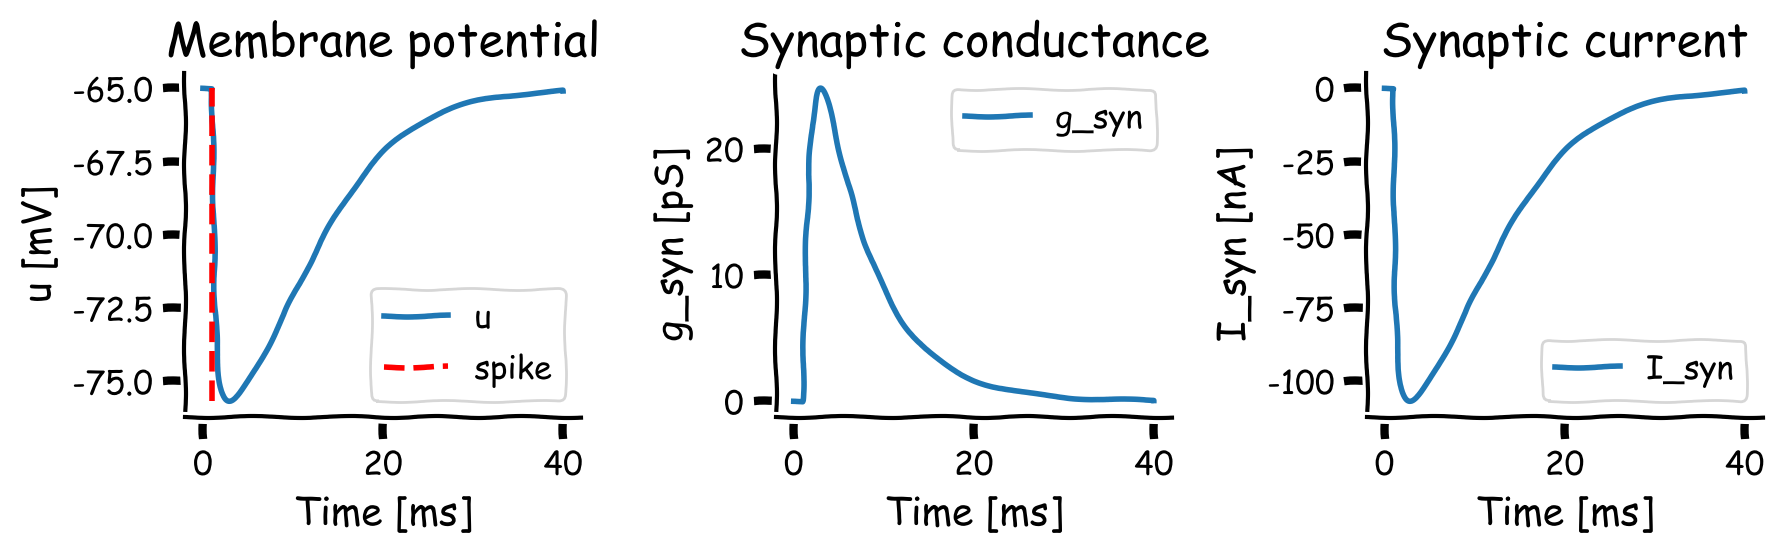

In [49]:
### GABA_A receptors

rec_spikes = np.array([1])

GABA_A = Synapse(u_rest, theta, tau_m, Cm, g_L, El, gbar_syn, 1, 6, 100, 1, ESyn_in)
u_t = GABA_A.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    GABA_A.plot_state(t, u_t, rec_spikes)

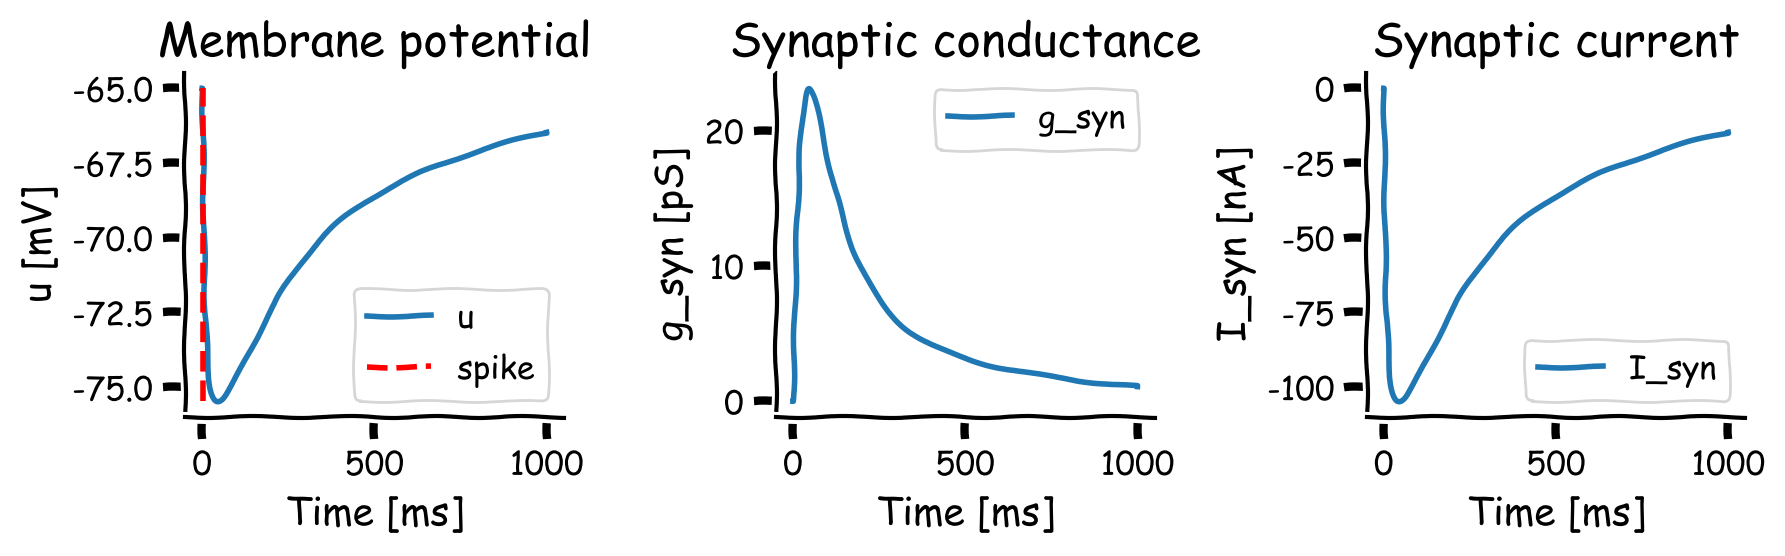

In [53]:
### GABA_B receptors

rec_spikes = np.array([1])
t = np.arange(0, 1000, 0.1)

GABA_B = Synapse(u_rest, theta, tau_m, Cm, g_L, El, gbar_syn, 25, 100, 500, 0.8, ESyn_in)
u_t = GABA_B.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    GABA_B.plot_state(t, u_t, rec_spikes)

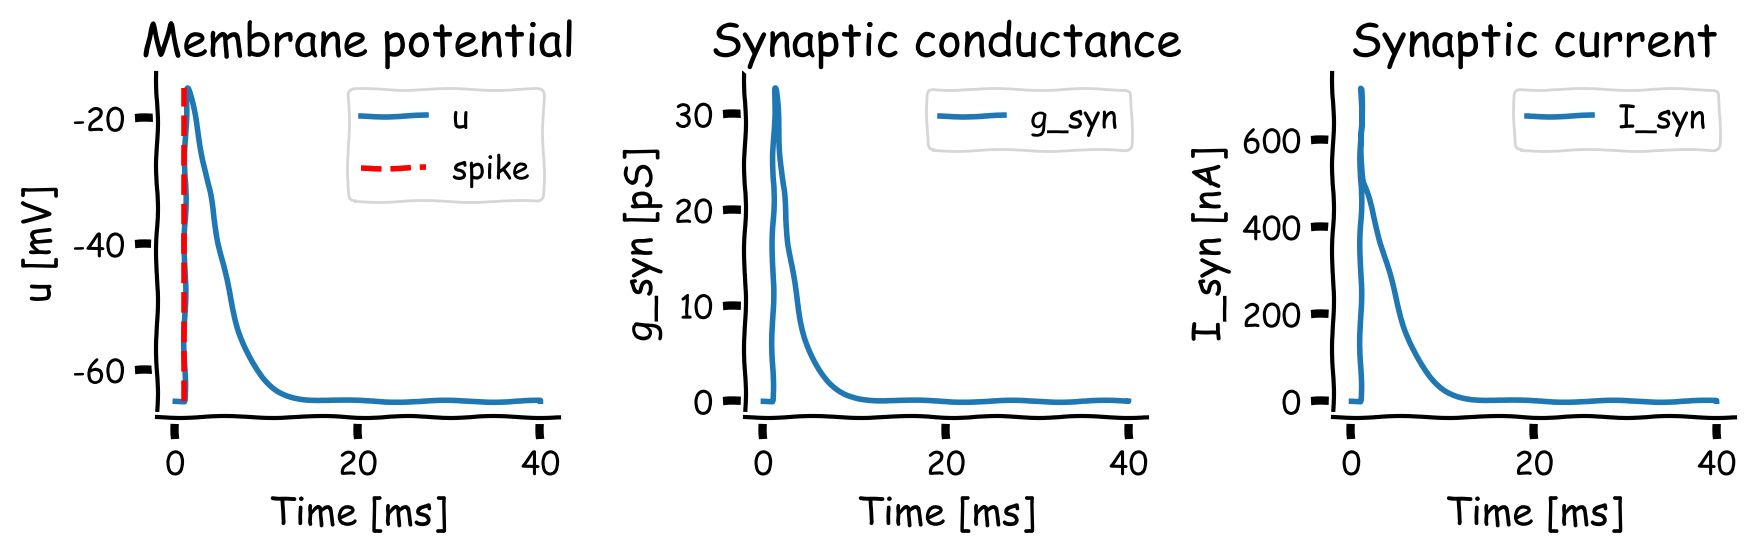

In [55]:
### AMPA receptors

rec_spikes = np.array([1])
t = np.arange(0, T+dt, dt)

AMPA = Synapse(u_rest, theta, tau_m, Cm, g_L, El, gbar_syn, 0.1, 2, 100, 1, ESyn_ex)
u_t = AMPA.simulate(t, dt, rec_spikes)

# Plot the results
with plt.xkcd():
    AMPA.plot_state(t, u_t, rec_spikes)

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Dendrites - cable equation</h1>
